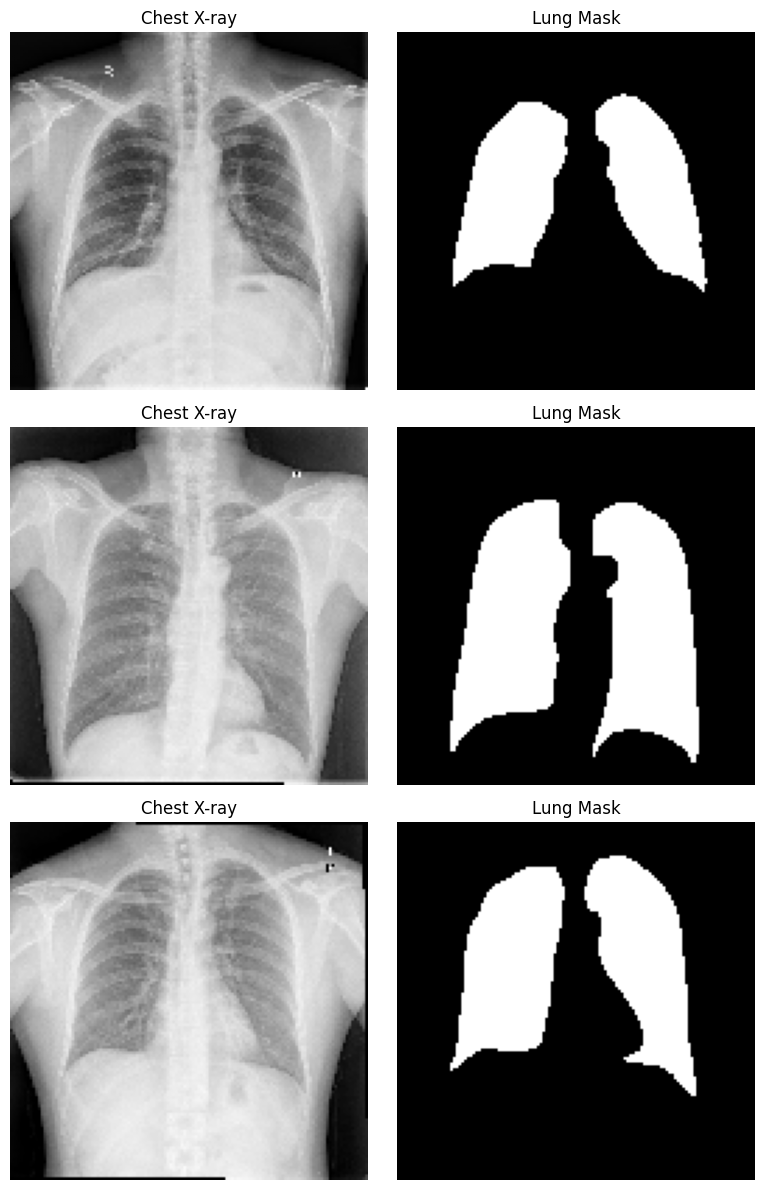

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 40s 317ms/step - dice_coef: 0.3074 - loss: 0.5958 - val_dice_coef: 0.4250 - val_loss: 0.3699
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - dice_coef: 0.4814 - loss: 0.3297 - val_dice_coef: 0.6150 - val_loss: 0.2505
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - dice_coef: 0.7275 - loss: 0.1957 - val_dice_coef: 0.7505 - val_loss: 0.3172
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - dice_coef: 0.8048 - loss: 0.1749 - val_dice_coef: 0.8441 - val_loss: 0.1381
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - dice_coef: 0.8584 - loss: 0.1263 - val_dice_coef: 0.8672 - val_loss: 0.1185
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - dice_coef: 0.8821 - loss: 0.1040 - val_dice_coef: 0.8709 - val_loss: 0.1254
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - dice_coef: 0.8857 - loss: 0.1045 - val_dice_coef: 0.8706 - val_loss: 0.1219
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - dice_coef: 0.9052 - loss: 0.0844 - va

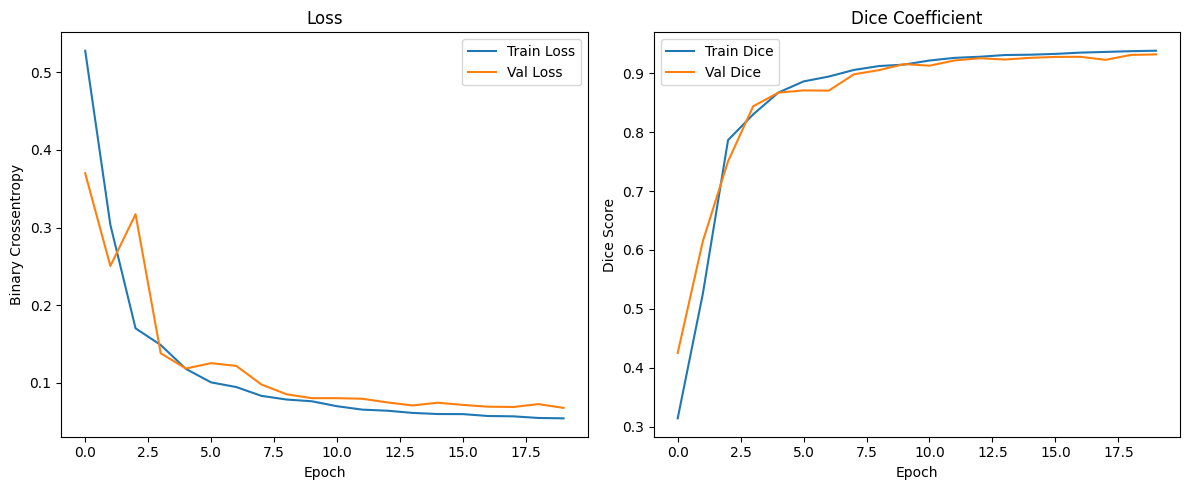

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step


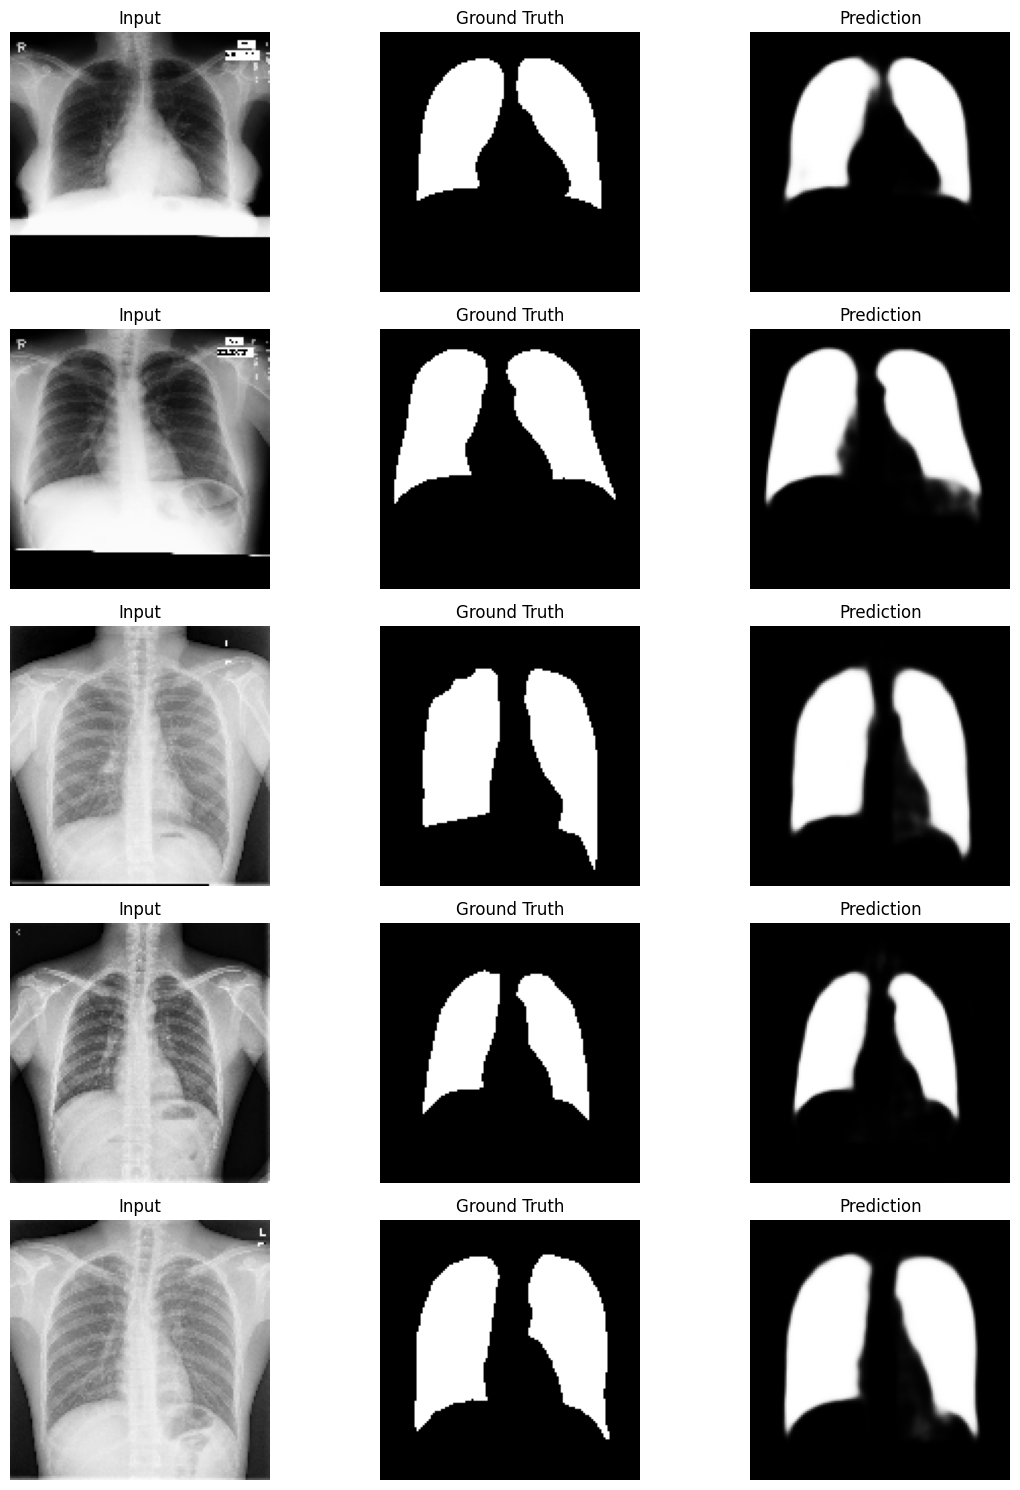

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
📊 Validation 평가 지표
Dice Coefficient (F1 Score): 0.9511
IoU (Jaccard Index):        0.9068
Precision:                  0.9689
Recall:                     0.9340
Accuracy:                   0.9756


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score


# 1) 데이터 로드
IMAGE_DIR = '/content/drive/MyDrive/images/chest_new/image'
MASK_DIR = '/content/drive/MyDrive/images/chest_new/mask'
image_paths = sorted(glob(os.path.join(IMAGE_DIR, '*.png')))
mask_paths = sorted(glob(os.path.join(MASK_DIR, '*.png')))

imgs = []
masks = []
for img_path, mask_path in zip(image_paths, mask_paths):
    img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(128,128))) / 255.0
    mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(128,128))) / 255.0
    imgs.append(img)
    masks.append(mask)

X = np.array(imgs)   # shape: (N,128,128,1)
y = np.array(masks)  # shape: (N,128,128,1)

# 2) Sample 데이터 시각화
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for i in range(3):
    axes[i,0].imshow(X[i].squeeze(), cmap='gray')
    axes[i,0].set_title('Chest X-ray')
    axes[i,0].axis('off')

    axes[i,1].imshow(y[i].squeeze(), cmap='gray')
    axes[i,1].set_title('Lung Mask')
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

# 3) train/validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 4) U-Net 모델 정의
smooth = 1.0
def unet(input_size=(128,128,1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p2)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    m6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(m6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    m7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(m7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)
    model = Model(inputs, outputs)
    return model

model = unet()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

# 5) 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20,
    shuffle=True
)

# 6) 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

# 7) 예측 결과 시각화
import random

num_samples = 5
indices = random.sample(range(len(X_val)), num_samples)
preds = model.predict(X_val[indices])

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
for i, idx in enumerate(indices):
    axes[i,0].imshow(X_val[idx].squeeze(), cmap='gray')
    axes[i,0].set_title('Input')
    axes[i,0].axis('off')

    axes[i,1].imshow(y_val[idx].squeeze(), cmap='gray')
    axes[i,1].set_title('Ground Truth')
    axes[i,1].axis('off')

    axes[i,2].imshow(preds[i].squeeze(), cmap='gray')
    axes[i,2].set_title('Prediction')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()


# 8) 평가지표 계산
# 전체 검증 세트 예측
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(np.uint8)

# Binary segmentation 평가용으로 flatten
y_true_flat = y_val.flatten()
y_pred_flat = y_val_pred.flatten()

# 지표 계산
dice = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
acc = accuracy_score(y_true_flat, y_pred_flat)

# 결과 출력
print("📊 Validation 평가 지표")
print(f"Dice Coefficient (F1 Score): {dice:.4f}")
print(f"IoU (Jaccard Index):        {iou:.4f}")
print(f"Precision:                  {precision:.4f}")
print(f"Recall:                     {recall:.4f}")
print(f"Accuracy:                   {acc:.4f}")

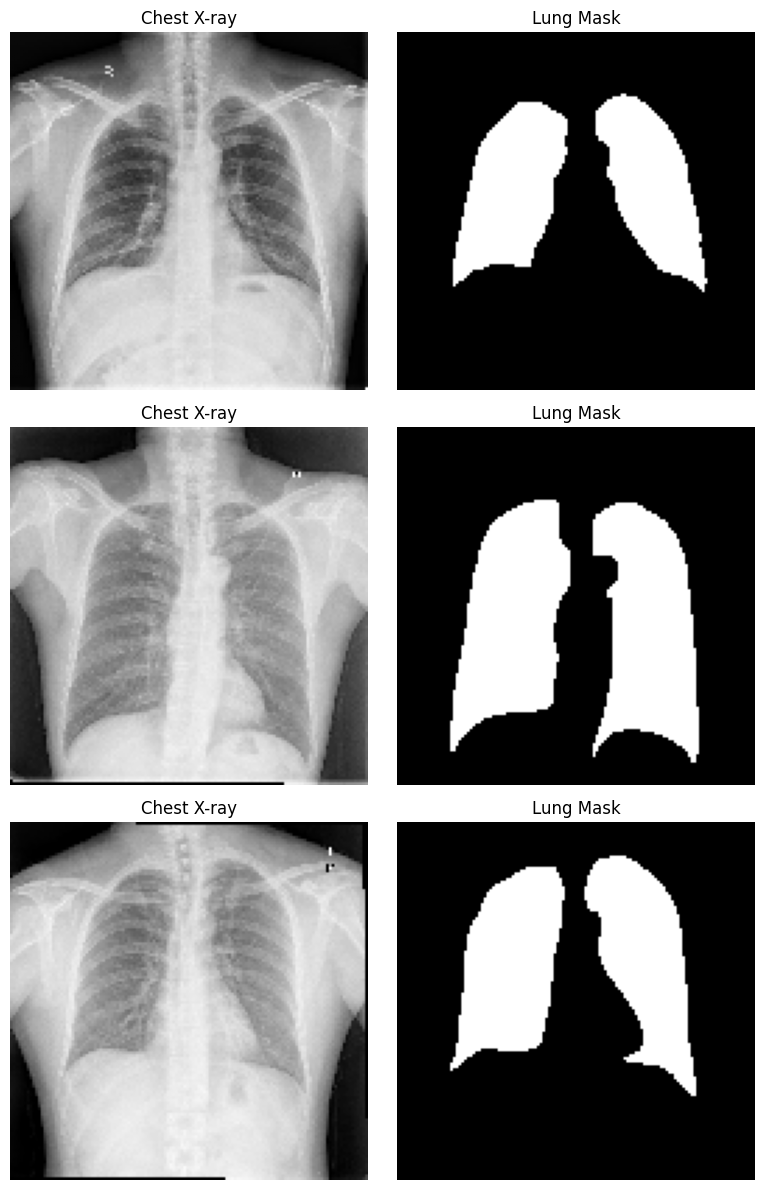

Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 20s 168ms/step - dice_coef: 0.3040 - loss: 0.6196 - val_dice_coef: 0.3741 - val_loss: 0.4201
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - dice_coef: 0.4286 - loss: 0.3736 - val_dice_coef: 0.6192 - val_loss: 0.2443
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - dice_coef: 0.7412 - loss: 0.2038 - val_dice_coef: 0.8266 - val_loss: 0.1532
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - dice_coef: 0.8312 - loss: 0.1516 - val_dice_coef: 0.8432 - val_loss: 0.1399
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - dice_coef: 0.8533 - loss: 0.1290 - val_dice_coef: 0.8747 - val_loss: 0.1156
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - dice_coef: 0.8761 - loss: 0.1106 - val_dice_coef: 0.8724 - val_loss: 0.1132
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - dice_coef: 0.8849 - loss: 0.1021 - val_dice_coef: 0.8904 - val_loss: 0.1042
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - dice_coef: 0.8997 - loss: 0.0882 - val

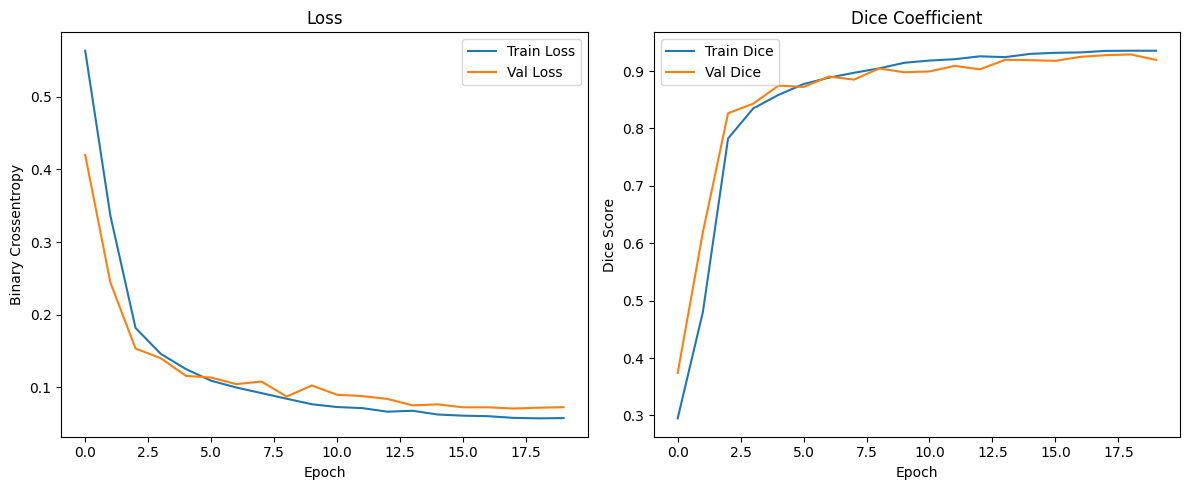

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step


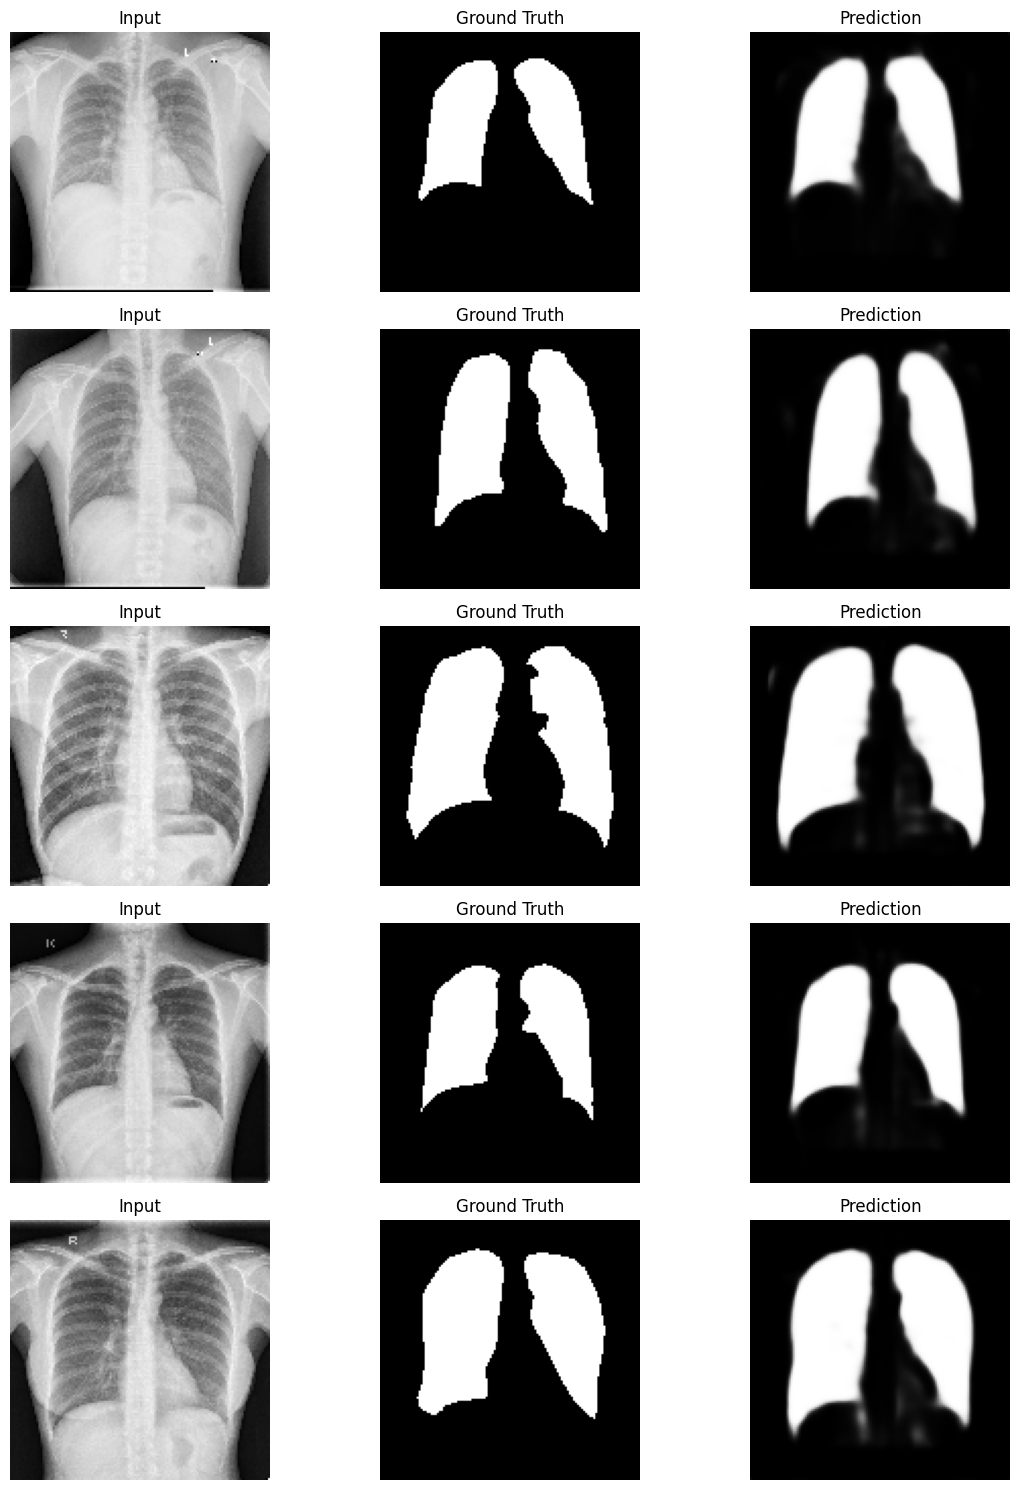

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
📊 Validation 평가 지표
Dice Coefficient (F1 Score): 0.9478
IoU (Jaccard Index):        0.9007
Precision:                  0.9422
Recall:                     0.9534
Accuracy:                   0.9732


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score


# 1) 데이터 로드 (이미 분할된 데이터셋)
# 훈련 데이터 경로
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/images/Heart-X-Ray/train_image'
TRAIN_MASK_DIR = '/content/drive/MyDrive/images/Heart-X-Ray/train_mask'

# 테스트 데이터 경로
TEST_IMAGE_DIR = '/content/drive/MyDrive/images/Heart-X-Ray/test_image'
TEST_MASK_DIR = '/content/drive/MyDrive/images/Heart-X-Ray/test_mask'

def load_data(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, '*.png')))
    mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = img_to_array(load_img(img_path, color_mode='grayscale', target_size=(128,128))) / 255.0
        mask = img_to_array(load_img(mask_path, color_mode='grayscale', target_size=(128,128))) / 255.0
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

# 데이터 로드
train_image, train_mask = load_data(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR)
test_image, test_mask = load_data(TEST_IMAGE_DIR, TEST_MASK_DIR)

# 2) Sample 데이터 시각화
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
for i in range(3):
    axes[i,0].imshow(X[i].squeeze(), cmap='gray')
    axes[i,0].set_title('Chest X-ray')
    axes[i,0].axis('off')

    axes[i,1].imshow(y[i].squeeze(), cmap='gray')
    axes[i,1].set_title('Lung Mask')
    axes[i,1].axis('off')

plt.tight_layout()
plt.show()

# 3) train/validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# 4) U-Net 모델 정의
smooth = 1.0
def unet(input_size=(128,128,1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    # Bottleneck
    c5 = Conv2D(512, 3, activation='relu', padding='same')(p2)
    c5 = Conv2D(512, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    m6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(m6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    m7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(m7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)
    model = Model(inputs, outputs)
    return model

model = unet()

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

# 5) 모델 학습
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20,
    shuffle=True
)

# 6) 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Train Dice')
plt.plot(history.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()

plt.tight_layout()
plt.show()

# 7) 예측 결과 시각화
import random

num_samples = 5
indices = random.sample(range(len(X_val)), num_samples)
preds = model.predict(X_val[indices])

fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3 * num_samples))
for i, idx in enumerate(indices):
    axes[i,0].imshow(X_val[idx].squeeze(), cmap='gray')
    axes[i,0].set_title('Input')
    axes[i,0].axis('off')

    axes[i,1].imshow(y_val[idx].squeeze(), cmap='gray')
    axes[i,1].set_title('Ground Truth')
    axes[i,1].axis('off')

    axes[i,2].imshow(preds[i].squeeze(), cmap='gray')
    axes[i,2].set_title('Prediction')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()


# 8) 평가지표 계산
# 전체 검증 세트 예측
y_val_pred_prob = model.predict(X_val)
y_val_pred = (y_val_pred_prob > 0.5).astype(np.uint8)

# Binary segmentation 평가용으로 flatten
y_true_flat = y_val.flatten()
y_pred_flat = y_val_pred.flatten()

# 지표 계산
dice = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
acc = accuracy_score(y_true_flat, y_pred_flat)

# 결과 출력
print("📊 Validation 평가 지표")
print(f"Dice Coefficient (F1 Score): {dice:.4f}")
print(f"IoU (Jaccard Index):        {iou:.4f}")
print(f"Precision:                  {precision:.4f}")
print(f"Recall:                     {recall:.4f}")
print(f"Accuracy:                   {acc:.4f}")